# **CCLEX LAKBAI FINAL OVERTURE: ESCAPE FROM PLANET SAGO**


## **Prerequisites and Setup**

In [ ]:
%pip install fuzzylogic

In [ ]:
# For General Use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace

# For FIS
from fuzzylogic.classes import Domain
from fuzzylogic.functions import gauss, sigmoid

# For Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## **Generator Model**

#### Helper Functions

In [ ]:
def fuzzy_OR(*args):
    return np.max(args)

def fuzzy_AND(*args):
    return np.min(args)

In [ ]:
def defuzzify(fuzzy_tup):
    return np.min([0*fuzzy_tup[0] + 50*fuzzy_tup[1] + 100*fuzzy_tup[2], 100])

### **Weather Condition Fuzzy Inference System**

#### Fuzzy Sets

##### For Heat

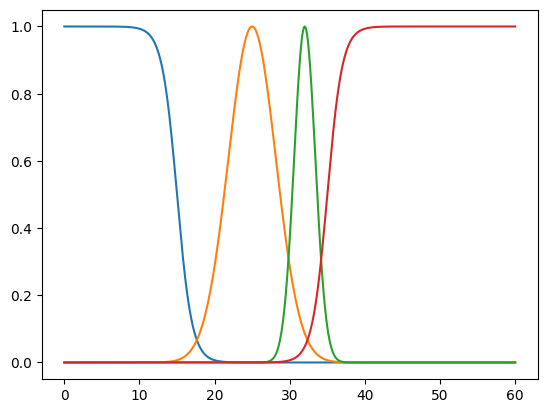

In [ ]:
# Define the domain (universe of discourse) for heat: 0°C to 60°C
heat = Domain("Heat", 0, 60, res=0.1)

# Define Gaussian membership functions for the heat levels
heat.normal = sigmoid(1, -1, 15)
heat.hazardous = gauss(c=25, b=0.05, c_m=1)
heat.caution = gauss(c=32, b=0.25, c_m=1)
heat.danger = sigmoid(1, 1, 35)

heat.normal.plot()
heat.hazardous.plot()
heat.caution.plot()
heat.danger.plot()

In [ ]:
def heat_membership(heat_value):
    normal = heat.normal(heat_value)
    hazardous = heat.hazardous(heat_value)
    caution = heat.caution(heat_value)
    danger = heat.danger(heat_value)
    return normal, hazardous, caution, danger

##### For Precipitation

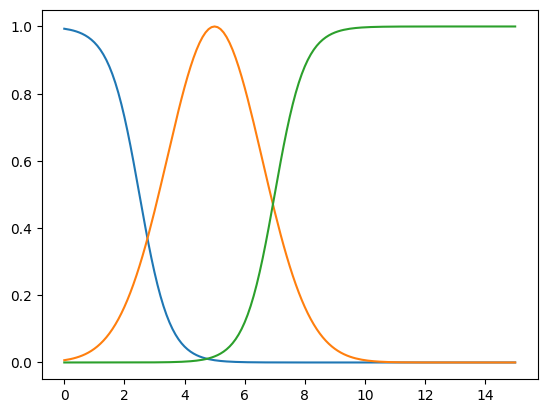

In [ ]:
# Define the universe of discourse for precipitation: 0 mm to 15 mm
precipitation = Domain("Precipitation", 0, 15, res=0.1)

precipitation.light = sigmoid(1, -2, 2.5)
precipitation.moderate = gauss(c=5, b=0.2, c_m=1)
precipitation.heavy = sigmoid(1, 2, 7)


precipitation.light.plot()
precipitation.moderate.plot()
precipitation.heavy.plot()

##### For Flood Risk

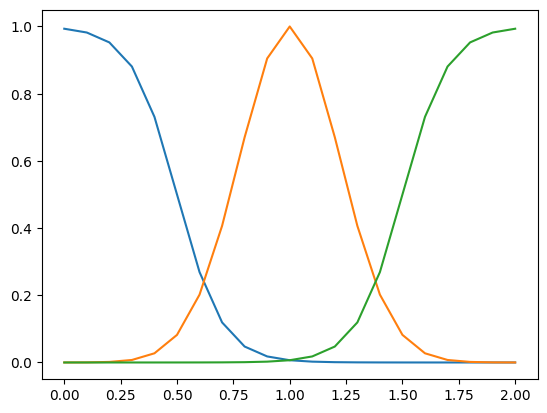

In [ ]:
# Define the universe of discourse for flood risk: Low (0), Medium (1), High (2)
flood_risk = Domain("Flood Risk", 0, 2, res=0.1)

flood_risk.low = sigmoid(1, -10, 0.5)
flood_risk.medium = gauss(c=1, b=10, c_m=1)
flood_risk.high = sigmoid(1, 10, 1.5)

flood_risk.low.plot()
flood_risk.medium.plot()
flood_risk.high.plot()

#### Fuzzy Rules

In [ ]:
# Bad condition: Severe combinations of flood hazard, precipitation, and heat.
def bad_weather_condition(f, h, p, flood_hazard, heat, precipitation):
    return fuzzy_OR(
        # HIGH FLOOD HAZARD
        fuzzy_AND(flood_hazard.high(f), precipitation.heavy(p)),
        fuzzy_AND(flood_hazard.high(f), precipitation.moderate(p)),
        fuzzy_AND(flood_hazard.high(f), precipitation.light(p)),

        fuzzy_AND(flood_hazard.high(f), precipitation.light(p), heat.danger(h)),
        fuzzy_AND(flood_hazard.high(f), precipitation.light(p), heat.caution(h)),

        # MODERATE FLOOD HAZARD
        fuzzy_AND(flood_hazard.medium(f), precipitation.heavy(p)),
        fuzzy_AND(flood_hazard.medium(f), precipitation.moderate(p)),

        fuzzy_AND(flood_hazard.medium(f), precipitation.light(p), heat.danger(h)),
        fuzzy_AND(flood_hazard.medium(f), precipitation.light(p), heat.caution(h)),

        # LOW FLOOD HAZARD
        fuzzy_AND(flood_hazard.low(f), precipitation.heavy(p)),

        fuzzy_AND(flood_hazard.low(f), precipitation.light(p), heat.danger(h)),
        fuzzy_AND(flood_hazard.low(f), precipitation.light(p), heat.caution(h))
    )


# Moderate condition: Intermediate risk with some caution needed.
def moderate_weather_condition(f, h, p, flood_hazard, heat, precipitation):
    return fuzzy_OR(
        # HIGH FLOOD HAZARD
        fuzzy_AND(flood_hazard.high(f), precipitation.light(p), heat.hazardous(h)),

        # MODERATE FLOOD HAZARD
        fuzzy_AND(flood_hazard.medium(f), precipitation.light(p), heat.hazardous(h)),
        fuzzy_AND(flood_hazard.medium(f), precipitation.moderate(p)),

        # LOW FLOOD HAZARD
        fuzzy_AND(flood_hazard.low(f), precipitation.light(p), heat.hazardous(h)),
        fuzzy_AND(flood_hazard.low(f), precipitation.moderate(p))
    )


# Good condition: Favorable combinations for normal activity.
def good_weather_condition(f, h, p, flood_hazard, heat, precipitation):
    return fuzzy_OR(
        # HIGH FLOOD HAZARD
        fuzzy_AND(flood_hazard.high(f), precipitation.light(p), heat.normal(h)),

        # MODERATE FLOOD HAZARD
        fuzzy_AND(flood_hazard.medium(f), precipitation.light(p), heat.normal(h)),

        # LOW FLOOD HAZARD
        fuzzy_AND(flood_hazard.low(f), precipitation.moderate(p)),
        fuzzy_AND(flood_hazard.low(f), precipitation.light(p), heat.normal(h))
    )

#### Fuzzy Function

In [ ]:
def fuzzy_weather_condition(f, h, p, flood_hazard, heat, precipitation):
  return (bad_weather_condition(f, h, p, flood_hazard, heat, precipitation),
          moderate_weather_condition(f, h, p, flood_hazard, heat, precipitation),
          good_weather_condition(f, h, p, flood_hazard, heat, precipitation))

### **II. Urban Density**

#### Fuzzy Sets

##### For Number of Key Areas

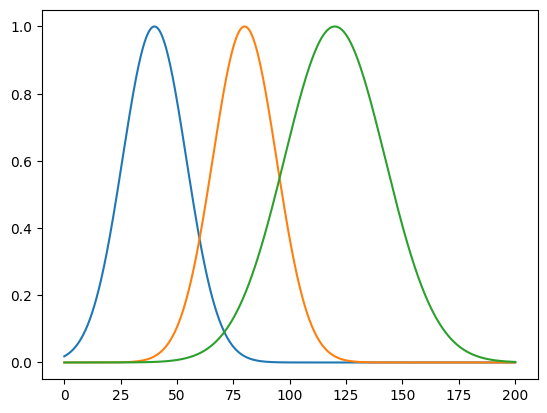

In [ ]:
# Define the domain (universe of discourse) for proximity to key areas (0-200)
key_areas = Domain("Key Areas", 0, 200, res=0.1)

# Define Gaussian membership functions for the categories: few, moderate, many
key_areas.few = gauss(c=40, b=0.0025, c_m=1)       # Centered at 50
key_areas.moderate = gauss(c=80, b=0.0025, c_m=1)  # Centered at 100
key_areas.many = gauss(c=120, b=0.001, c_m=1)      # Centered at 150

key_areas.few.plot()
key_areas.moderate.plot()
key_areas.many.plot()

##### For Population

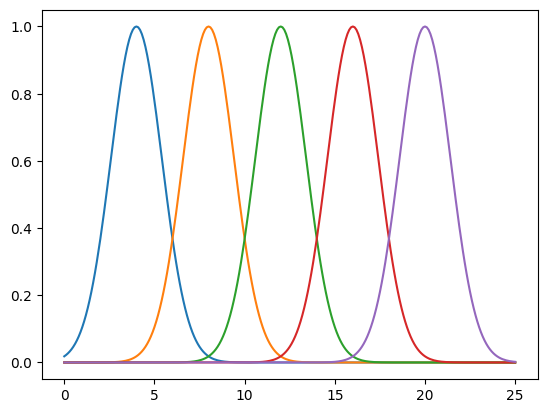

In [ ]:
# Define the domain (universe of discourse) for population (0-25)
population = Domain("Population", 0, 25, res=0.1)

# Define Gaussian membership functions for the categories
population.very_low = gauss(c=4, b=0.25, c_m=1)      # Centered at 4
population.low = gauss(c=8, b=0.25, c_m=1)           # Centered at 8
population.moderate = gauss(c=12, b=0.25, c_m=1)     # Centered at 12
population.high = gauss(c=16, b=0.25, c_m=1)         # Centered at 16
population.very_high = gauss(c=20, b=0.25, c_m=1)    # Centered at 20

population.very_low.plot()
population.low.plot()
population.moderate.plot()
population.high.plot()
population.very_high.plot()

### Fuzzy Rules

In [ ]:
def low_urban_density(a, p, key_areas, population):
    return fuzzy_OR(
        # Few key areas
        fuzzy_AND(key_areas.few(a), population.very_low(p)),
        fuzzy_AND(key_areas.few(a), population.low(p)),
        fuzzy_AND(key_areas.few(a), population.moderate(p)),

        # Moderate key areas
        fuzzy_AND(key_areas.moderate(a), population.very_low(p)),
        fuzzy_AND(key_areas.moderate(a), population.low(p)),

        # Many key areas
        # no case for that
    )


def moderate_urban_density(a, p, key_areas, population):
    return fuzzy_OR(
        # Few key areas
        fuzzy_AND(key_areas.few(a), population.high(p)),
        fuzzy_AND(key_areas.few(a), population.very_high(p)),

        # Moderate key areas
        fuzzy_AND(key_areas.moderate(a), population.moderate(p)),

        # Many key areas
        # no case for that
    )


def high_urban_density(a, p, key_areas, population):
    return fuzzy_OR(
        # Few key areas
        # no case for that

        # Moderate key areas
        fuzzy_AND(key_areas.moderate(a), population.high(p)),
        fuzzy_AND(key_areas.moderate(a), population.very_high(p)),

        # Many key areas
        fuzzy_AND(key_areas.many(a), population.low(p)),
        fuzzy_AND(key_areas.many(a), population.moderate(p)),
        fuzzy_AND(key_areas.many(a), population.high(p)),
        fuzzy_AND(key_areas.many(a), population.very_high(p))
    )

#### Fuzzy Function

In [ ]:
def fuzzy_urban_density(a, p, key_areas, population):
  return (low_urban_density(a, p, key_areas, population),
          moderate_urban_density(a, p, key_areas, population),
          high_urban_density(a, p, key_areas, population))

### **III. Sidewalk Capacity**

#### Fuzzy Sets

##### For Walkway Width

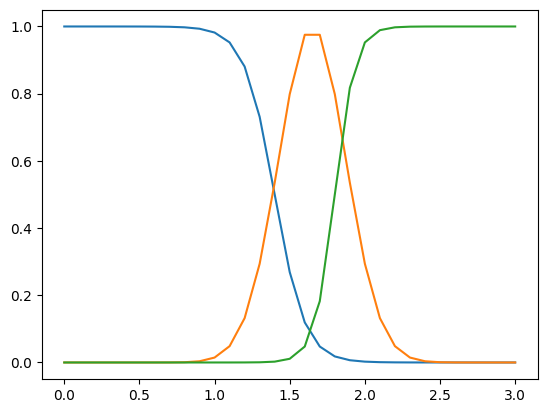

In [ ]:
walkway_width = Domain("walkway_width", 0, 3, res=0.1)

walkway_width.narrow = sigmoid(1, -10, 1.4)
walkway_width.midsize = gauss(c=1.65, b=10, c_m=1)
walkway_width.wide = sigmoid(1, 15, 1.8)

walkway_width.narrow.plot()
walkway_width.midsize.plot()
walkway_width.wide.plot()

##### For Zoning Area

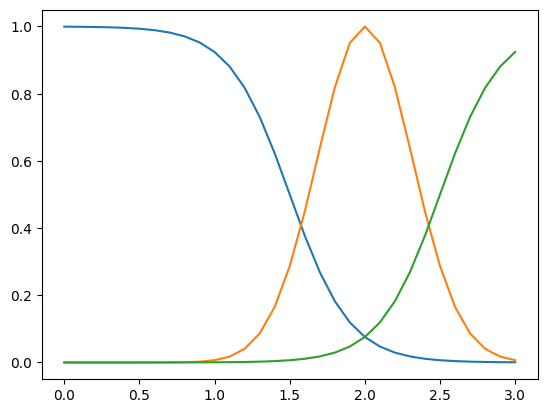

In [ ]:
zoning_area = Domain("zoning_area", 0, 3, res=0.1)

zoning_area.commercial = sigmoid(1, -5, 1.5)
zoning_area.residential = gauss(c=2, b=5, c_m=1)
zoning_area.industrial = sigmoid(1, 5, 2.5)

zoning_area.commercial.plot()
zoning_area.residential.plot()
zoning_area.industrial.plot()

#### Fuzzy Rules

In [ ]:
def low_sidewalk_capacity(w, z, walkway_width, zoning_area):
    return fuzzy_OR(
        # Rule 1: Narrow walkway, commercial area
        fuzzy_AND(walkway_width.narrow(w), zoning_area.commercial(z))
    )

def moderate_sidewalk_capacity(w, z, walkway_width, zoning_area):
    return fuzzy_OR(
        # Rule 1: Midsize walkway, commercial area
        fuzzy_AND(walkway_width.midsize(w), zoning_area.commercial(z)),

        # Rule 2: Narrow walkway, industrial area
        fuzzy_AND(walkway_width.narrow(w), zoning_area.industrial(z)),

        # Rule 3: Midsize walkway, industrial area
        fuzzy_AND(walkway_width.midsize(w), zoning_area.industrial(z)),

        # Rule 4: Narrow walkway, residential area
        fuzzy_AND(walkway_width.narrow(w), zoning_area.residential(z))
    )

def high_sidewalk_capacity(w, z, walkway_width, zoning_area):
    return fuzzy_OR(
        # Rule 1: Wide walkway, commercial area
        fuzzy_AND(walkway_width.wide(w), zoning_area.commercial(z)),

        # Rule 2: Wide walkway, industrial area
        fuzzy_AND(walkway_width.wide(w), zoning_area.industrial(z)),

        # Rule 3: Midsize walkway, residential area
        fuzzy_AND(walkway_width.midsize(w), zoning_area.residential(z)),

        # Rule 4: Wide walkway, residential area
        fuzzy_AND(walkway_width.wide(w), zoning_area.residential(z))
    )

#### Fuzzy Function

In [ ]:
def fuzzy_sidewalk_capacity(w, z, walkway_width, zoning_area):
    return (low_sidewalk_capacity(w, z, walkway_width, zoning_area),
            moderate_sidewalk_capacity(w, z, walkway_width, zoning_area),
            high_sidewalk_capacity(w, z, walkway_width, zoning_area))

### **IV. Safety Risk**

#### Fuzzy Sets

##### For Gradient

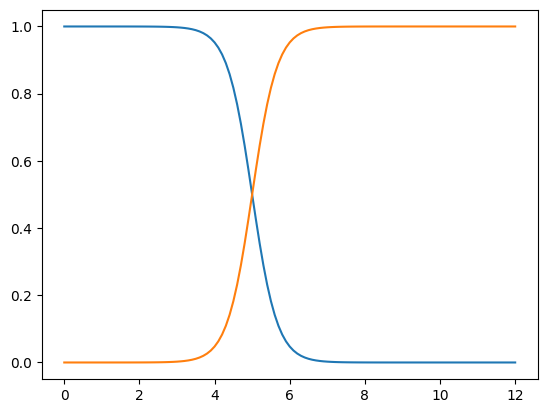

In [ ]:
gradient = Domain("gradient", 0, 12, res=0.1)

gradient.accessible = sigmoid(1, -3, 5)
gradient.inaccessible = sigmoid(1, 3, 5)

gradient.accessible.plot()
gradient.inaccessible.plot()

##### For Surface

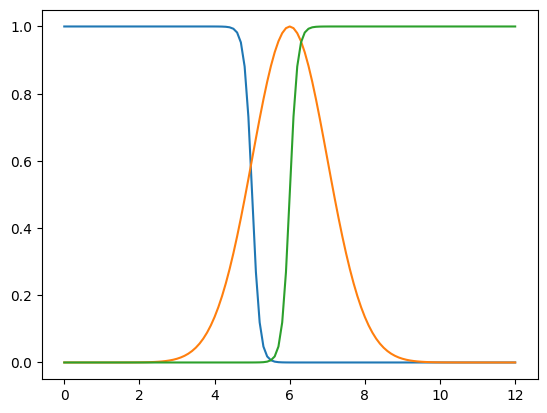

In [ ]:
surface = Domain("surface", 0, 12, res=0.1)

surface.smooth = sigmoid(1, -10, 5)
surface.cracked = gauss(c=6, b=0.5, c_m=1)
surface.damaged = sigmoid(1, 10, 6)

surface.smooth.plot()
surface.cracked.plot()
surface.damaged.plot()

##### For the Presence of Street Furniture

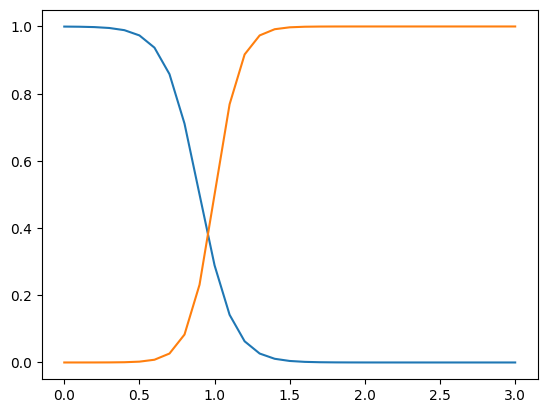

In [ ]:
street_furniture = Domain("street_furniture", 0, 3, res=0.1)

street_furniture.obstructs = sigmoid(1, -9, 0.9)
street_furniture.does_not_obstruct = sigmoid(1, 12, 1)

street_furniture.obstructs.plot()
street_furniture.does_not_obstruct.plot()

##### For Border Buffer

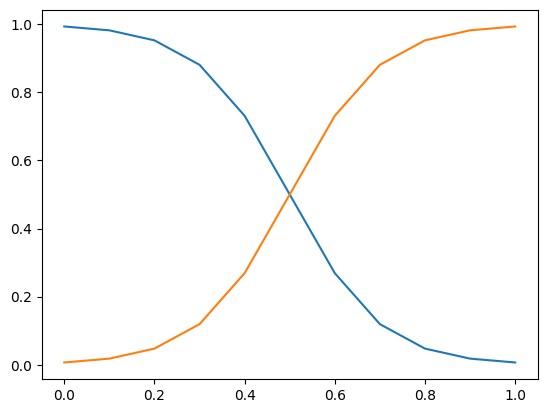

In [ ]:
border_buffer = Domain("border_buffer", 0, 1, res=0.1)

border_buffer.exists = sigmoid(1, -10, 0.5)
border_buffer.does_not_exist = sigmoid(1, 10, 0.5)

border_buffer.exists.plot()
border_buffer.does_not_exist.plot()

##### For Lighting

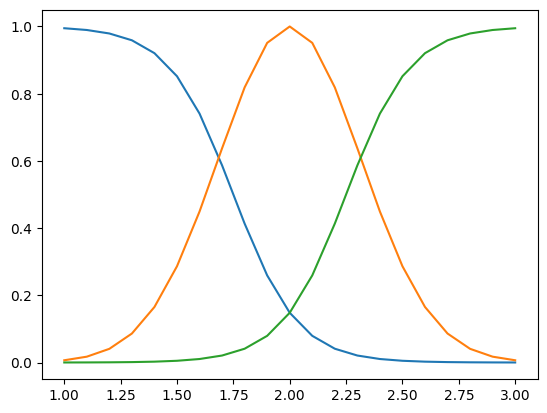

In [ ]:
lighting = Domain("lighting", 1, 3, res=0.1)

lighting.poor = sigmoid(1, -7, 1.75)
lighting.adequate = gauss(c=2, b=5, c_m=1)
lighting.excellent = sigmoid(1, 7, 2.25)

lighting.poor.plot()
lighting.adequate.plot()
lighting.excellent.plot()

#### Fuzzy Rules

In [ ]:
def moderate_safety_risk(g, s, sf, l, bb, gradient, surface, street_furniture, lighting, border_buffer):
    return fuzzy_OR(
        # Rule 1: Accessible, Smooth, Does not Obstruct, Does not Exist, Adequate
        fuzzy_AND(gradient.accessible(g), surface.smooth(s), street_furniture.does_not_obstruct(sf), border_buffer.does_not_exist(bb), lighting.adequate(l)),

        # Rule 2: Accessible, Smooth, Obstructs, Exists, Poor
        fuzzy_AND(gradient.accessible(g), surface.smooth(s), street_furniture.obstructs(sf), border_buffer.exists(bb), lighting.poor(l)),

        # Rule 3: Accessible, Smooth, Obstructs, Exists, Adequate
        fuzzy_AND(gradient.accessible(g), surface.smooth(s), street_furniture.obstructs(sf), border_buffer.exists(bb), lighting.adequate(l)),

        # Rule 4: Accessible, Smooth, Obstructs, Does not Exist, Excellent
        fuzzy_AND(gradient.accessible(g), surface.smooth(s), street_furniture.obstructs(sf), border_buffer.does_not_exist(bb), lighting.excellent(l)),

        # Rule 5: Accessible, Smooth, Does not Obstruct, Exists, Poor
        fuzzy_AND(gradient.accessible(g), surface.smooth(s), street_furniture.does_not_obstruct(sf), border_buffer.exists(bb), lighting.poor(l)),

        # Rule 6: Accessible, Smooth, Does not Obstruct, Does not Exist, Excellent
        fuzzy_AND(gradient.accessible(g), surface.smooth(s), street_furniture.does_not_obstruct(sf), border_buffer.does_not_exist(bb), lighting.excellent(l)),

        # Rule 7: Accessible, Cracked, Obstructs, Exists, Adequate
        fuzzy_AND(gradient.accessible(g), surface.cracked(s), street_furniture.obstructs(sf), border_buffer.exists(bb), lighting.adequate(l)),

        # Rule 8: Accessible, Cracked, Obstructs, Exists, Excellent
        fuzzy_AND(gradient.accessible(g), surface.cracked(s), street_furniture.obstructs(sf), border_buffer.exists(bb), lighting.excellent(l)),

        # Rule 9: Accessible, Cracked, Obstructs, Does not Exist, Excellent
        fuzzy_AND(gradient.accessible(g), surface.cracked(s), street_furniture.obstructs(sf), border_buffer.does_not_exist(bb), lighting.excellent(l)),

        # Rule 10: Accessible, Cracked, Does not Obstruct, Exists, Poor
        fuzzy_AND(gradient.accessible(g), surface.cracked(s), street_furniture.does_not_obstruct(sf), border_buffer.exists(bb), lighting.poor(l)),

        # Rule 11: Accessible, Cracked, Does not Obstruct, Does not Exist, Adequate
        fuzzy_AND(gradient.accessible(g), surface.cracked(s), street_furniture.does_not_obstruct(sf), border_buffer.does_not_exist(bb), lighting.adequate(l)),

        # Rule 12: Accessible, Cracked, Does not Obstruct, Does not Exist, Excellent
        fuzzy_AND(gradient.accessible(g), surface.cracked(s), street_furniture.does_not_obstruct(sf), border_buffer.does_not_exist(bb), lighting.excellent(l)),

        # Rule 13: Accessible, Damaged, Does not Obstruct, Exists, Adequate
        fuzzy_AND(gradient.accessible(g), surface.damaged(s), street_furniture.does_not_obstruct(sf), border_buffer.exists(bb), lighting.adequate(l)),

        # Rule 14: Accessible, Damaged, Does not Obstruct, Exists, Excellent
        fuzzy_AND(gradient.accessible(g), surface.damaged(s), street_furniture.does_not_obstruct(sf), border_buffer.exists(bb), lighting.excellent(l)),

        # Rule 15: Inaccessible, Smooth, Obstructs, Exists, Adequate
        fuzzy_AND(gradient.inaccessible(g), surface.smooth(s), street_furniture.obstructs(sf), border_buffer.exists(bb), lighting.adequate(l)),

        # Rule 16: Inaccessible, Smooth, Obstructs, Exists, Excellent
        fuzzy_AND(gradient.inaccessible(g), surface.smooth(s), street_furniture.obstructs(sf), border_buffer.exists(bb), lighting.excellent(l)),

        # Rule 17: Inaccessible, Smooth, Obstructs, Does not Exist, Excellent
        fuzzy_AND(gradient.inaccessible(g), surface.smooth(s), street_furniture.obstructs(sf), border_buffer.does_not_exist(bb), lighting.excellent(l)),

        # Rule 18: Inaccessible, Smooth, Does not Obstruct, Exists, Adequate
        fuzzy_AND(gradient.inaccessible(g), surface.smooth(s), street_furniture.does_not_obstruct(sf), border_buffer.exists(bb), lighting.adequate(l)),

        # Rule 19: Inaccessible, Smooth, Does not Obstruct, Does not Exist, Excellent
        fuzzy_AND(gradient.inaccessible(g), surface.smooth(s), street_furniture.does_not_obstruct(sf), border_buffer.does_not_exist(bb), lighting.excellent(l)),

        # Rule 20: Inaccessible, Cracked, Obstructs, Exists, Adequate
        fuzzy_AND(gradient.inaccessible(g), surface.cracked(s), street_furniture.obstructs(sf), border_buffer.exists(bb), lighting.adequate(l)),

        # Rule 21: Inaccessible, Cracked, Obstructs, Exists, Excellent
        fuzzy_AND(gradient.inaccessible(g), surface.cracked(s), street_furniture.obstructs(sf), border_buffer.exists(bb), lighting.excellent(l)),

        # Rule 22: Inaccessible, Cracked, Obstructs, Does not Exist, Excellent
        fuzzy_AND(gradient.inaccessible(g), surface.cracked(s), street_furniture.obstructs(sf), border_buffer.does_not_exist(bb), lighting.excellent(l)),

        # Rule 23: Inaccessible, Cracked, Does not Obstruct, Exists, Adequate
        fuzzy_AND(gradient.inaccessible(g), surface.cracked(s), street_furniture.does_not_obstruct(sf), border_buffer.exists(bb), lighting.adequate(l)),

        # Rule 24: Inaccessible, Cracked, Does not Obstruct, Exists, Excellent
        fuzzy_AND(gradient.inaccessible(g), surface.cracked(s), street_furniture.does_not_obstruct(sf), border_buffer.exists(bb), lighting.excellent(l)),

        # Rule 25: Inaccessible, Cracked, Does not Obstruct, Does not Exist, Excellent
        fuzzy_AND(gradient.inaccessible(g), surface.cracked(s), street_furniture.does_not_obstruct(sf), border_buffer.does_not_exist(bb), lighting.excellent(l))
    )


In [ ]:
def low_safety_risk(g, s, sf, l, bb, gradient, surface, street_furniture, lighting, border_buffer):
    return fuzzy_OR(
        # Rule 1: Accessible, Smooth, Does not Obstruct, Exists, Adequate
        fuzzy_AND(gradient.accessible(g), surface.smooth(s), street_furniture.does_not_obstruct(sf), border_buffer.exists(bb), lighting.adequate(l)),

        # Rule 2: Accessible, Smooth, Does not Obstruct, Exists, Excellent
        fuzzy_AND(gradient.accessible(g), surface.smooth(s), street_furniture.does_not_obstruct(sf), border_buffer.exists(bb), lighting.excellent(l)),

        # Rule 3: Accessible, Cracked, Does not Obstruct, Exists, Adequate
        fuzzy_AND(gradient.accessible(g), surface.cracked(s), street_furniture.does_not_obstruct(sf), border_buffer.exists(bb), lighting.adequate(l)),

        # Rule 4: Accessible, Cracked, Does not Obstruct, Exists, Excellent
        fuzzy_AND(gradient.accessible(g), surface.cracked(s), street_furniture.does_not_obstruct(sf), border_buffer.exists(bb), lighting.excellent(l)),

        # Rule 5: Accessible, Smooth, Obstructs, Exists, Excellent
        fuzzy_AND(gradient.accessible(g), surface.smooth(s), street_furniture.obstructs(sf), border_buffer.exists(bb), lighting.excellent(l)),

        # Rule 6: Inaccessible, Smooth, Does not Obstruct, Exists, Excellent
        fuzzy_AND(gradient.inaccessible(g), surface.smooth(s), street_furniture.does_not_obstruct(sf), border_buffer.exists(bb), lighting.excellent(l))
    )


In [ ]:
def high_safety_risk(g, s, sf, l, bb, gradient, surface, street_furniture, lighting, border_buffer):
    return fuzzy_OR(
        # Rule 1: Accessible, Smooth, Obstructs, Does not Exist, Poor
        fuzzy_AND(gradient.accessible(g), surface.smooth(s), street_furniture.obstructs(sf), border_buffer.does_not_exist(bb), lighting.poor(l)),

        # Rule 2: Accessible, Smooth, Obstructs, Does not Exist, Adequate
        fuzzy_AND(gradient.accessible(g), surface.smooth(s), street_furniture.obstructs(sf), border_buffer.does_not_exist(bb), lighting.adequate(l)),

        # Rule 3: Accessible, Smooth, Does not Obstruct, Does not Exist, Poor
        fuzzy_AND(gradient.accessible(g), surface.smooth(s), street_furniture.does_not_obstruct(sf), border_buffer.does_not_exist(bb), lighting.poor(l)),

        # Rule 4: Accessible, Cracked, Obstructs, Exists, Poor
        fuzzy_AND(gradient.accessible(g), surface.cracked(s), street_furniture.obstructs(sf), border_buffer.exists(bb), lighting.poor(l)),

        # Rule 5: Accessible, Cracked, Obstructs, Does not Exist, Poor
        fuzzy_AND(gradient.accessible(g), surface.cracked(s), street_furniture.obstructs(sf), border_buffer.does_not_exist(bb), lighting.poor(l)),

        # Rule 6: Accessible, Cracked, Obstructs, Does not Exist, Adequate
        fuzzy_AND(gradient.accessible(g), surface.cracked(s), street_furniture.obstructs(sf), border_buffer.does_not_exist(bb), lighting.adequate(l)),

        # Rule 7: Accessible, Cracked, Does not Obstruct, Does not Exist, Poor
        fuzzy_AND(gradient.accessible(g), surface.cracked(s), street_furniture.does_not_obstruct(sf), border_buffer.does_not_exist(bb), lighting.poor(l)),

        # Rule 8: Accessible, Damaged, Obstructs, Exists, Poor
        fuzzy_AND(gradient.accessible(g), surface.damaged(s), street_furniture.obstructs(sf), border_buffer.exists(bb), lighting.poor(l)),

        # Rule 9: Accessible, Damaged, Obstructs, Exists, Adequate
        fuzzy_AND(gradient.accessible(g), surface.damaged(s), street_furniture.obstructs(sf), border_buffer.exists(bb), lighting.adequate(l)),

        # Rule 10: Accessible, Damaged, Obstructs, Exists, Excellent
        fuzzy_AND(gradient.accessible(g), surface.damaged(s), street_furniture.obstructs(sf), border_buffer.exists(bb), lighting.excellent(l)),

        # Rule 11: Accessible, Damaged, Obstructs, Does not Exist, Poor
        fuzzy_AND(gradient.accessible(g), surface.damaged(s), street_furniture.obstructs(sf), border_buffer.does_not_exist(bb), lighting.poor(l)),

        # Rule 12: Accessible, Damaged, Obstructs, Does not Exist, Adequate
        fuzzy_AND(gradient.accessible(g), surface.damaged(s), street_furniture.obstructs(sf), border_buffer.does_not_exist(bb), lighting.adequate(l)),

        # Rule 13: Accessible, Damaged, Obstructs, Does not Exist, Excellent
        fuzzy_AND(gradient.accessible(g), surface.damaged(s), street_furniture.obstructs(sf), border_buffer.does_not_exist(bb), lighting.excellent(l)),

        # Rule 14: Accessible, Damaged, Does not Obstruct, Exists, Poor
        fuzzy_AND(gradient.accessible(g), surface.damaged(s), street_furniture.does_not_obstruct(sf), border_buffer.exists(bb), lighting.poor(l)),

        # Rule 15: Accessible, Damaged, Does not Obstruct, Does not Exist, Poor
        fuzzy_AND(gradient.accessible(g), surface.damaged(s), street_furniture.does_not_obstruct(sf), border_buffer.does_not_exist(bb), lighting.poor(l)),

        # Rule 16: Accessible, Damaged, Does not Obstruct, Does not Exist, Adequate
        fuzzy_AND(gradient.accessible(g), surface.damaged(s), street_furniture.does_not_obstruct(sf), border_buffer.does_not_exist(bb), lighting.adequate(l)),

        # Rule 17: Accessible, Damaged, Does not Obstruct, Does not Exist, Excellent
        fuzzy_AND(gradient.accessible(g), surface.damaged(s), street_furniture.does_not_obstruct(sf), border_buffer.does_not_exist(bb), lighting.excellent(l)),

        # Rule 18: Inaccessible, Smooth, Obstructs, Exists, Poor
        fuzzy_AND(gradient.inaccessible(g), surface.smooth(s), street_furniture.obstructs(sf), border_buffer.exists(bb), lighting.poor(l)),

        # Rule 19: Inaccessible, Smooth, Obstructs, Does not Exist, Poor
        fuzzy_AND(gradient.inaccessible(g), surface.smooth(s), street_furniture.obstructs(sf), border_buffer.does_not_exist(bb), lighting.poor(l)),

        # Rule 20: Inaccessible, Smooth, Obstructs, Does not Exist, Adequate
        fuzzy_AND(gradient.inaccessible(g), surface.smooth(s), street_furniture.obstructs(sf), border_buffer.does_not_exist(bb), lighting.adequate(l)),

        # Rule 21: Inaccessible, Smooth, Does not Obstruct, Exists, Poor
        fuzzy_AND(gradient.inaccessible(g), surface.smooth(s), street_furniture.does_not_obstruct(sf), border_buffer.exists(bb), lighting.poor(l)),

        # Rule 22: Inaccessible, Smooth, Does not Obstruct, Does not Exist, Poor
        fuzzy_AND(gradient.inaccessible(g), surface.smooth(s), street_furniture.does_not_obstruct(sf), border_buffer.does_not_exist(bb), lighting.poor(l)),

        # Rule 23: Inaccessible, Smooth, Does not Obstruct, Does not Exist, Adequate
        fuzzy_AND(gradient.inaccessible(g), surface.smooth(s), street_furniture.does_not_obstruct(sf), border_buffer.does_not_exist(bb), lighting.adequate(l)),

        # Rule 24: Inaccessible, Cracked, Obstructs, Exists, Poor
        fuzzy_AND(gradient.inaccessible(g), surface.cracked(s), street_furniture.obstructs(sf), border_buffer.exists(bb), lighting.poor(l)),

        # Rule 25: Inaccessible, Cracked, Obstructs, Does not Exist, Poor
        fuzzy_AND(gradient.inaccessible(g), surface.cracked(s), street_furniture.obstructs(sf), border_buffer.does_not_exist(bb), lighting.poor(l)),

        # Rule 26: Inaccessible, Cracked, Obstructs, Does not Exist, Adequate
        fuzzy_AND(gradient.inaccessible(g), surface.cracked(s), street_furniture.obstructs(sf), border_buffer.does_not_exist(bb), lighting.adequate(l)),

        # Rule 27: Inaccessible, Cracked, Does not Obstruct, Exists, Poor
        fuzzy_AND(gradient.inaccessible(g), surface.cracked(s), street_furniture.does_not_obstruct(sf), border_buffer.exists(bb), lighting.poor(l)),

        # Rule 28: Inaccessible, Cracked, Does not Obstruct, Does not Exist, Poor
        fuzzy_AND(gradient.inaccessible(g), surface.cracked(s), street_furniture.does_not_obstruct(sf), border_buffer.does_not_exist(bb), lighting.poor(l)),

        # Rule 29: Inaccessible, Cracked, Does not Obstruct, Does not Exist, Adequate
        fuzzy_AND(gradient.inaccessible(g), surface.cracked(s), street_furniture.does_not_obstruct(sf), border_buffer.does_not_exist(bb), lighting.adequate(l)),

        # Rule 30: Inaccessible, Damaged, Obstructs, Exists, Poor
        fuzzy_AND(gradient.inaccessible(g), surface.damaged(s), street_furniture.obstructs(sf), border_buffer.exists(bb), lighting.poor(l)),

        # Rule 31: Inaccessible, Damaged, Obstructs, Exists, Adequate
        fuzzy_AND(gradient.inaccessible(g), surface.damaged(s), street_furniture.obstructs(sf), border_buffer.exists(bb), lighting.adequate(l)),

        # Rule 32: Inaccessible, Damaged, Obstructs, Exists, Excellent
        fuzzy_AND(gradient.inaccessible(g), surface.damaged(s), street_furniture.obstructs(sf), border_buffer.exists(bb), lighting.excellent(l)),

        # Rule 33: Inaccessible, Damaged, Obstructs, Does not Exist, Poor
        fuzzy_AND(gradient.inaccessible(g), surface.damaged(s), street_furniture.obstructs(sf), border_buffer.does_not_exist(bb), lighting.poor(l)),

        # Rule 34: Inaccessible, Damaged, Obstructs, Does not Exist, Adequate
        fuzzy_AND(gradient.inaccessible(g), surface.damaged(s), street_furniture.obstructs(sf), border_buffer.does_not_exist(bb), lighting.adequate(l)),

        # Rule 35: Inaccessible, Damaged, Obstructs, Does not Exist, Excellent
        fuzzy_AND(gradient.inaccessible(g), surface.damaged(s), street_furniture.obstructs(sf), border_buffer.does_not_exist(bb), lighting.excellent(l)),

        # Rule 36: Inaccessible, Damaged, Does not Obstruct, Exists, Poor
        fuzzy_AND(gradient.inaccessible(g), surface.damaged(s), street_furniture.does_not_obstruct(sf), border_buffer.exists(bb), lighting.poor(l)),

        # Rule 37: Inaccessible, Damaged, Does not Obstruct, Exists, Adequate
        fuzzy_AND(gradient.inaccessible(g), surface.damaged(s), street_furniture.does_not_obstruct(sf), border_buffer.exists(bb), lighting.adequate(l)),

        # Rule 38: Inaccessible, Damaged, Does not Obstruct, Exists, Excellent
        fuzzy_AND(gradient.inaccessible(g), surface.damaged(s), street_furniture.does_not_obstruct(sf), border_buffer.exists(bb), lighting.excellent(l)),

        # Rule 39: Inaccessible, Damaged, Does not Obstruct, Does not Exist, Poor
        fuzzy_AND(gradient.inaccessible(g), surface.damaged(s), street_furniture.does_not_obstruct(sf), border_buffer.does_not_exist(bb), lighting.poor(l)),

        # Rule 40: Inaccessible, Damaged, Does not Obstruct, Does not Exist, Adequate
        fuzzy_AND(gradient.inaccessible(g), surface.damaged(s), street_furniture.does_not_obstruct(sf), border_buffer.does_not_exist(bb), lighting.adequate(l)),

        # Rule 41: Inaccessible, Damaged, Does not Obstruct, Does not Exist, Excellent
        fuzzy_AND(gradient.inaccessible(g), surface.damaged(s), street_furniture.does_not_obstruct(sf), border_buffer.does_not_exist(bb), lighting.excellent(l))
    )


#### Fuzzy Function

In [ ]:
def fuzzy_safety_risk(g, s, sf, l, bb, gradient, surface, street_furniture, lighting, border_buffer):
  return (low_safety_risk(g, s, sf, l, bb, gradient, surface, street_furniture, lighting, border_buffer),
          moderate_safety_risk(g, s, sf, l, bb, gradient, surface, street_furniture, lighting, border_buffer),
          high_safety_risk(g, s, sf, l, bb, gradient, surface, street_furniture, lighting, border_buffer))

### **V. Accessibility**

#### Fuzzy Rules

In [ ]:
def accessible (weather_condition,  urban_density, road_capacity, safety_level):
    '''
        Params:
          weather_condition should have three values: good, moderate, bad
          urban_density should have three values: low, moderate, high
          road_capacity should have three values: low, moderate, high
          safety_level should have three values: low, moderate, high

        These values are pre-computed using the sub FIS
    '''

    return fuzzy_OR(
        # WEATHER CONDITION = GOOD

            # URBAN DENSITY = HIGH
                # ROAD CAPACITY = HIGH
        fuzzy_AND(weather_condition.good, urban_density.high, road_capacity.high, safety_level.moderate),
        fuzzy_AND(weather_condition.good, urban_density.high, road_capacity.high, safety_level.high),
                # ROAD CAPACITY = MODERATE
        fuzzy_AND(weather_condition.good, urban_density.high, road_capacity.moderate, safety_level.moderate),
        fuzzy_AND(weather_condition.good, urban_density.high, road_capacity.moderate, safety_level.high),

            # URBAN DENSITY = MODERATE
                # ROAD CAPACITY = HIGH
        fuzzy_AND(weather_condition.good, urban_density.moderate, road_capacity.high, safety_level.moderate),
        fuzzy_AND(weather_condition.good, urban_density.moderate, road_capacity.high, safety_level.high),
                # ROAD CAPACITY = MDOERATE
        fuzzy_AND(weather_condition.good, urban_density.moderate, road_capacity.moderate, safety_level.moderate),
        fuzzy_AND(weather_condition.good, urban_density.moderate, road_capacity.moderate, safety_level.high),

            # URBAN DESNITY = LOW
                # ROAD CAPACITY = HIGH
        fuzzy_AND(weather_condition.good, urban_density.low, road_capacity.high, safety_level.low),
        fuzzy_AND(weather_condition.good, urban_density.low, road_capacity.high, safety_level.moderate),
        fuzzy_AND(weather_condition.good, urban_density.low, road_capacity.high, safety_level.high),
                # ROAD CAPACITY = MODERATE
        fuzzy_AND(weather_condition.good, urban_density.low, road_capacity.moderate, safety_level.moderate),
        fuzzy_AND(weather_condition.good, urban_density.low, road_capacity.moderate, safety_level.high),
                # ROAD CAPACITY = LOW
        fuzzy_AND(weather_condition.good, urban_density.low, road_capacity.low, safety_level.moderate),
        fuzzy_AND(weather_condition.good, urban_density.low, road_capacity.low, safety_level.high),

        # WEATHER CONDITION = MODERATE

            # URBAN DENSITY = HIGH
                # ROAD CAPACITY = HIGH
        fuzzy_AND(weather_condition.moderate, urban_density.high, road_capacity.high, safety_level.high),

            # URBAN DENSITY = MODERATE
                # ROAD CAPACITY = HIGH
        fuzzy_AND(weather_condition.moderate, urban_density.moderate, road_capacity.high, safety_level.moderate),
        fuzzy_AND(weather_condition.moderate, urban_density.moderate, road_capacity.high, safety_level.high),
                # ROAD CAPACITY = MODERATE
        fuzzy_AND(weather_condition.moderate, urban_density.moderate, road_capacity.moderate, safety_level.moderate),
        fuzzy_AND(weather_condition.moderate, urban_density.moderate, road_capacity.moderate, safety_level.high),

            # URBAN DENSITY = LOW
                # ROAD CAPACITY = HIGH
        fuzzy_AND(weather_condition.moderate, urban_density.low, road_capacity.high, safety_level.moderate),
        fuzzy_AND(weather_condition.moderate, urban_density.low, road_capacity.high, safety_level.high),
                # ROAD CAPACITY = MODERATE
        fuzzy_AND(weather_condition.moderate, urban_density.low, road_capacity.moderate, safety_level.moderate),
        fuzzy_AND(weather_condition.moderate, urban_density.low, road_capacity.moderate, safety_level.high),
                # ROAD CAPACITY = LOW
        fuzzy_AND(weather_condition.moderate, urban_density.low, road_capacity.low, safety_level.moderate),
        fuzzy_AND(weather_condition.moderate, urban_density.low, road_capacity.low, safety_level.high),

        # WEATHER CONDITION = BAD

            # URBAN DENSITY = HIGH
                # ROAD CAPACITY = HIGH
        fuzzy_AND(weather_condition.bad, urban_density.high, road_capacity.high, safety_level.high),
                # ROAD CAPACITY = MODERATE
        fuzzy_AND(weather_condition.bad, urban_density.high, road_capacity.moderate, safety_level.high),

            # URBAN DENSITY = MODERATE
                # ROAD CAPACITY = HIGH
        fuzzy_AND(weather_condition.bad, urban_density.moderate, road_capacity.high, safety_level.high),
                # ROAD CAPACITY = MODERATE
        fuzzy_AND(weather_condition.bad, urban_density.moderate, road_capacity.moderate, safety_level.high),

            # URBAN DENSITY = LOW
                # ROAD CAPACITY = HIGH
        fuzzy_AND(weather_condition.bad, urban_density.low, road_capacity.high, safety_level.high),
                # ROAD CAPACITY = MODERATE
        fuzzy_AND(weather_condition.bad, urban_density.low, road_capacity.moderate, safety_level.high)
    )


def not_accessible(weather_condition, urban_density, road_capacity, safety_level):
    return fuzzy_OR(
        # WEATHER CONDITION = GOOD

            # URBAN DENSITY = HIGH
                # ROAD CAPACITY = HIGH
        fuzzy_AND(weather_condition.good, urban_density.high, road_capacity.high, safety_level.low),
                # ROAD CAPACITY = MODERATE
        fuzzy_AND(weather_condition.good, urban_density.high, road_capacity.moderate, safety_level.low),
                # ROAD CAPACITY = LOW
        fuzzy_AND(weather_condition.good, urban_density.high, road_capacity.low, safety_level.low),
        fuzzy_AND(weather_condition.good, urban_density.high, road_capacity.low, safety_level.moderate),
        fuzzy_AND(weather_condition.good, urban_density.high, road_capacity.low, safety_level.high),

            # URBAN DENSITY = MODERATE
                # ROAD CAPACITY = HIGH
        fuzzy_AND(weather_condition.good, urban_density.moderate, road_capacity.high, safety_level.low),
                # ROAD CAPACITY = MODERATE
        fuzzy_AND(weather_condition.good, urban_density.moderate, road_capacity.moderate, safety_level.low),
                # ROAD CAPACITY = LOW
        fuzzy_AND(weather_condition.good, urban_density.moderate, road_capacity.low, safety_level.low),
        fuzzy_AND(weather_condition.good, urban_density.moderate, road_capacity.low, safety_level.moderate),
        fuzzy_AND(weather_condition.good, urban_density.moderate, road_capacity.low, safety_level.high),

            # URBAN DENSITY = LOW
                # ROAD CAPACITY = MODERATE
        fuzzy_AND(weather_condition.good, urban_density.low, road_capacity.moderate, safety_level.low),
                # ROAD CAPACITY = LOW
        fuzzy_AND(weather_condition.good, urban_density.low, road_capacity.low, safety_level.low),

        # WEATHER CONDITION = MODERATE

            # URBAN DENSITY = HIGH
                # ROAD CAPACITY = HIGH
        fuzzy_AND(weather_condition.moderate, urban_density.high, road_capacity.high, safety_level.low),
        fuzzy_AND(weather_condition.moderate, urban_density.high, road_capacity.high, safety_level.moderate),
                # ROAD CAPACITY = MODERATE
        fuzzy_AND(weather_condition.moderate, urban_density.high, road_capacity.moderate, safety_level.low),
        fuzzy_AND(weather_condition.moderate, urban_density.high, road_capacity.moderate, safety_level.moderate),
        fuzzy_AND(weather_condition.moderate, urban_density.high, road_capacity.moderate, safety_level.high),
                # ROAD CAPACITY = LOW
        fuzzy_AND(weather_condition.moderate, urban_density.high, road_capacity.low, safety_level.low),
        fuzzy_AND(weather_condition.moderate, urban_density.high, road_capacity.low, safety_level.moderate),
        fuzzy_AND(weather_condition.moderate, urban_density.high, road_capacity.low, safety_level.high),

            # URBAN DENSITY = MODERATE
                # ROAD CAPACITY = HIGH
        fuzzy_AND(weather_condition.moderate, urban_density.moderate, road_capacity.high, safety_level.low),
                # ROAD CAPACITY = MODERATE
        fuzzy_AND(weather_condition.moderate, urban_density.moderate, road_capacity.moderate, safety_level.low),
                # ROAD CAPACITY = LOW
        fuzzy_AND(weather_condition.moderate, urban_density.moderate, road_capacity.low, safety_level.low),
        fuzzy_AND(weather_condition.moderate, urban_density.moderate, road_capacity.low, safety_level.moderate),
        fuzzy_AND(weather_condition.moderate, urban_density.moderate, road_capacity.low, safety_level.high),

            # URBAN DENSITY = LOW
                # ROAD CAPACITY = HIGH
        fuzzy_AND(weather_condition.moderate, urban_density.low, road_capacity.high, safety_level.low),
                # ROAD CAPACITY = MODERATE
        fuzzy_AND(weather_condition.moderate, urban_density.low, road_capacity.moderate, safety_level.low),
                # ROAD CAPACITY = LOW
        fuzzy_AND(weather_condition.moderate, urban_density.low, road_capacity.low, safety_level.low),

        # WEATHER CONDITION = BAD

            # URBAN DENSITY = HIGH
                # ROAD CAPACITY = HIGH
        fuzzy_AND(weather_condition.bad, urban_density.high, road_capacity.high, safety_level.low),
        fuzzy_AND(weather_condition.bad, urban_density.high, road_capacity.high, safety_level.moderate),
                # ROAD CAPACITY = MODERATE
        fuzzy_AND(weather_condition.bad, urban_density.high, road_capacity.moderate, safety_level.low),
        fuzzy_AND(weather_condition.bad, urban_density.high, road_capacity.moderate, safety_level.moderate),
                # ROAD CAPACITY = LOW
        fuzzy_AND(weather_condition.bad, urban_density.high, road_capacity.low, safety_level.low),
        fuzzy_AND(weather_condition.bad, urban_density.high, road_capacity.low, safety_level.moderate),
        fuzzy_AND(weather_condition.bad, urban_density.high, road_capacity.low, safety_level.high),

            # URBAN DENSITY = MODERATE
                # ROAD CAPACITY = HIGH
        fuzzy_AND(weather_condition.bad, urban_density.moderate, road_capacity.high, safety_level.low),
        fuzzy_AND(weather_condition.bad, urban_density.moderate, road_capacity.high, safety_level.moderate),
                # ROAD CAPACITY = MODERATE
        fuzzy_AND(weather_condition.bad, urban_density.moderate, road_capacity.moderate, safety_level.low),
        fuzzy_AND(weather_condition.bad, urban_density.moderate, road_capacity.moderate, safety_level.moderate),
        fuzzy_AND(weather_condition.bad, urban_density.moderate, road_capacity.moderate, safety_level.high),
                # ROAD CAPACITY = LOW
        fuzzy_AND(weather_condition.bad, urban_density.moderate, road_capacity.low, safety_level.low),
        fuzzy_AND(weather_condition.bad, urban_density.moderate, road_capacity.low, safety_level.moderate),
        fuzzy_AND(weather_condition.bad, urban_density.moderate, road_capacity.low, safety_level.high),

            # URBAN DENSITY = LOW
                # ROAD CAPACITY = HIGH
        fuzzy_AND(weather_condition.bad, urban_density.low, road_capacity.high, safety_level.low),
        fuzzy_AND(weather_condition.bad, urban_density.low, road_capacity.high, safety_level.moderate),
                # ROAD CAPACITY = MODERATE
        fuzzy_AND(weather_condition.bad, urban_density.low, road_capacity.moderate, safety_level.low),
        fuzzy_AND(weather_condition.bad, urban_density.low, road_capacity.moderate, safety_level.moderate),
                # ROAD CAPACITY = LOW
        fuzzy_AND(weather_condition.bad, urban_density.low, road_capacity.low, safety_level.low),
        fuzzy_AND(weather_condition.bad, urban_density.low, road_capacity.low, safety_level.moderate),
        fuzzy_AND(weather_condition.bad, urban_density.low, road_capacity.low, safety_level.high)
    )

#### Fuzzy Functions

In [ ]:
def classify(fuzzy_tup):
    arg_max_idx = np.argmax(fuzzy_tup)
    result = np.zeros(shape=(len(fuzzy_tup), ))
    result[arg_max_idx] = 1
    return tuple(result)

def fuzzy_accessibility(weather_condition_tup, urban_density_tup, sidewalk_capacity_tup, safety_level_tup):
    return (accessible(weather_condition_tup, urban_density_tup, sidewalk_capacity_tup, safety_level_tup),
            not_accessible(weather_condition_tup, urban_density_tup, sidewalk_capacity_tup, safety_level_tup))

## **Regressor Model**

### Split training and testing data

In [ ]:
# Function to split features and target
def split_features_target(df, test_size):

  """
  df should contain these columns ['Weather Conditions', 'Road Capacity', 'Urban Density', 'Safety Risk', 'Accessibility']
  """

  cols = df.columns
  print(cols)

  classes = cols[-1:]  # Target is 'Accessibility'
  print(classes)
  features = cols[0:4]  # Select the first 4 features
  print(features)

  X = df[features].values
  Y = df[classes].values

  return train_test_split(X, Y, test_size=test_size)

### Logistic Regression Model

In [ ]:
# Function to train and evaluate the logistic regression model
def train_logistic_regression(X_train, X_test, Y_train, Y_test):
  log_accessibility_model = LogisticRegression(penalty="l2").fit(X_train, Y_train)
  score = log_accessibility_model.score(X_test, Y_test)
  return log_accessibility_model, score

### Get accessibility score probability

In [ ]:
# Function to get predicted probabilities
def get_probabilities(model, val):
  return model.predict_log_proba(val)

# **Test Area**

## Weather Condition Test

In [ ]:
# Function use for weather condition

f = 2   # flood risk
h = 24  # heat
p = 8   # precipitation

print(fuzzy_weather_condition(f, h, p, flood_risk, heat, precipitation))
print(defuzzify(fuzzy_weather_condition(2, 24, 8, flood_risk, heat, precipitation)))

(0.8807970779778823, 4.5399929762484854e-05, 1.670142184809518e-05)
0.003940138672933761


## Urban Density Test

In [ ]:
# Function for use for urban density

a = 100  # number of key areas
p = 20   # population count

print(fuzzy_urban_density(a, p, key_areas, population))
print(defuzzify(fuzzy_urban_density(a, p, key_areas, population)))

(1.1253517471925912e-07, 0.00012340980408667956, 0.6703200460356393)
67.03817509376827


## Sidewalk Capacity Test

In [ ]:
# Function for sidewalk capacity

w = 1.5
z = 2

print(fuzzy_sidewalk_capacity(w, z, walkway_width, zoning_area))
print(defuzzify(fuzzy_sidewalk_capacity(w, z, walkway_width, zoning_area)))

(0.07585818002124355, 0.26894142136999494, 0.7985162187593773)
93.29869294443748


## Safety Risk Level Test

In [ ]:
# Function for safety risk level

g = 4
s = 2
sf = 0
l = 3
bb = 1

print(fuzzy_safety_risk(g, s, sf, l, bb, gradient, surface, street_furniture, lighting, border_buffer))
print(defuzzify(fuzzy_safety_risk(g, s, sf, l, bb, gradient, surface, street_furniture, lighting, border_buffer)))

(0.0066928509242848554, 0.9525741268224334, 0.006737946999085467)
48.30250104103022


## Logistic Regression Test

In [ ]:
n_samples = 10

# Generate random values for weather
f = np.random.choice([0, 1, 2], n_samples)  # Discrete values for f (0, 1, 2)
h = np.random.uniform(0, 60, n_samples)     # Continuous values for h (0-60)
p = np.random.uniform(0, 15, n_samples)     # Continuous values for p (0-15)

# Generate random values for urban density
ka = np.random.uniform(0, 200, n_samples)
pop = np.random.uniform(0, 25, n_samples)

# Generate random vlaues for safety risk
w = np.random.uniform(0, 3, n_samples)
z = np.random.uniform(0, 3, n_samples)

# Generate random values for safety risk
g = np.random.uniform(0, 12, n_samples)
s = np.random.uniform(0, 12, n_samples)
sf = np.random.uniform(0, 3, n_samples)
bb = np.random.choice([0, 1], n_samples)
l = np.random.choice([1, 2 ,3], n_samples)

In [ ]:
# Generate fuzzy and defuzzified values for weather condition
fuzz_weather_condition = [fuzzy_weather_condition(f[i], h[i], p[i], flood_risk, heat, precipitation) for i in range(n_samples)]
fuzz_urban_density = [fuzzy_urban_density(ka[i], pop[i], key_areas, population) for i in range(n_samples)]
fuzz_sidewalk_capacity = [fuzzy_sidewalk_capacity(w[i], z[i], walkway_width, zoning_area) for i in range(n_samples)]
fuzz_safety_risk = [fuzzy_safety_risk(g[i], s[i], sf[i], l[i], bb[i], gradient, surface, street_furniture, lighting, border_buffer) for i in range(n_samples)]

In [ ]:
a, b, c = fuzz_weather_condition[0]
print(a, b, c)

0.6955008175093981 4.5399929762484854e-05 3.059022269256247e-07


In [ ]:
# Initialize an empty DataFrame
df = pd.DataFrame(columns=['weather_condition', 'urban_density', 'sidewalk_capacity', 'safety_risk', 'accessibility'])

# Initialize a list to store the rows
data = []

# Loop through samples and calculate fuzzy values, then store in DataFrame
for i in range(n_samples):
  # Calculate fuzzy values for each aspect
  bad_weather_condition, moderate_weather_condition, good_weather_condition = fuzz_weather_condition[i]
  low_urban_density, moderate_urban_density, high_urban_density = fuzz_urban_density[i]
  low_sidewalk_capacity, moderate_sidewalk_capacity, high_sidewalk_capacity = fuzz_sidewalk_capacity[i]
  low_safety_risk, moderate_safety_risk, high_safety_risk = fuzz_safety_risk[i]

  crisp_weather_condition = defuzzify(fuzz_weather_condition[i])
  crisp_urban_density = defuzzify(fuzz_urban_density[i])
  crisp_sidewalk_capacity = defuzzify(fuzz_sidewalk_capacity[i])
  crisp_safety_risk = defuzzify(fuzz_safety_risk[i])

  # Classify accessibility using the fuzzy values
  accessibility = classify(fuzzy_accessibility(
      weather_condition_tup=SimpleNamespace(
          bad=bad_weather_condition,
          moderate=moderate_weather_condition,
          good=good_weather_condition),
      urban_density_tup=SimpleNamespace(
          low=low_urban_density,
          moderate=moderate_urban_density,
          high=high_urban_density),
      sidewalk_capacity_tup=SimpleNamespace(
          low=low_sidewalk_capacity,
          moderate=moderate_sidewalk_capacity,
          high=high_sidewalk_capacity),
      safety_level_tup=SimpleNamespace(
          low=low_safety_risk,
          moderate=moderate_safety_risk,
          high=high_safety_risk)
  ))

  # Store the defuzzified values and accessibility in the data list
  data.append({
      'weather_condition': crisp_weather_condition,
      'urban_density': crisp_urban_density,
      'sidewalk_capacity': crisp_sidewalk_capacity,
      'safety_risk': crisp_safety_risk,
      'accessibility': np.argmax(accessibility)   # NOTE THIS SINCE FUNCTION RETURNS MEMBERSHIPS
  })

# Create the DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Output the final DataFrame with only defuzzified values
df


,weather_condition,urban_density,sidewalk_capacity,safety_risk,accessibility
0,0.002301,58.557698,71.096603,85.541596,0
1,0.000005,4.100768,99.852282,1.084973,1
2,51.198444,0.006500,61.676823,96.455381,0
3,100.000000,79.788979,31.763254,76.583339,0
4,100.000000,21.008718,89.586617,64.470077,0
5,100.000000,47.668666,0.397999,75.728285,1
6,53.434987,2.711946,100.000000,100.000000,0
7,13.693473,0.013661,38.989288,1.757683,1
8,0.000238,91.228120,1.247248,50.334643,1
9,1.299929,0.000016,42.165540,63.600817,0


In [ ]:
X_train, X_test, Y_train, Y_test = split_features_target(df, 0.40)

Index(['weather_condition', 'urban_density', 'sidewalk_capacity',
       'safety_risk', 'accessibility'],
      dtype='object')
Index(['accessibility'], dtype='object')
Index(['weather_condition', 'urban_density', 'sidewalk_capacity',
       'safety_risk'],
      dtype='object')


In [ ]:
lrm, score = train_logistic_regression(X_train, X_test, Y_train, Y_test)
print(score)

0.75


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
X_test

array([[5.11984442e+01, 6.49975287e-03, 6.16768235e+01, 9.64553808e+01],
       [2.37860319e-04, 9.12281199e+01, 1.24724788e+00, 5.03346425e+01],
       [2.30058671e-03, 5.85576980e+01, 7.10966031e+01, 8.55415962e+01],
       [5.34349870e+01, 2.71194627e+00, 1.00000000e+02, 1.00000000e+02]])

In [ ]:
get_probabilities(lrm, X_test) # Broken

array([[-4.41446585e-07, -1.46332090e+01],
       [-1.74778509e-01, -1.83035254e+00],
       [-5.31641398e-11, -2.36576371e+01],
       [-9.55961976e-11, -2.30708882e+01]])

In [ ]:
lrm.predict_proba(X_test)

array([[9.99999559e-01, 4.41446487e-07],
       [8.39642974e-01, 1.60357026e-01],
       [1.00000000e+00, 5.31641368e-11],
       [1.00000000e+00, 9.55961811e-11]])

In [ ]:
lrm.predict_log_proba(X_test)

array([[-4.41446585e-07, -1.46332090e+01],
       [-1.74778509e-01, -1.83035254e+00],
       [-5.31641398e-11, -2.36576371e+01],
       [-9.55961976e-11, -2.30708882e+01]])

In [ ]:
prob_in_class_1_given_X = np.exp(np.round(lrm.predict_log_proba(X_test)[:,1],3)) ## This can serve as the index of being accessible
prob_in_class_1_given_X

array([4.41538773e-07, 1.60413568e-01, 5.31448453e-11, 9.55854982e-11])

In [ ]:
prob_in_class_1_given_X = np.exp(np.round(lrm.predict_proba(X_test)[:,1],3))
prob_in_class_1_given_X

array([1.        , 1.17351087, 1.        , 1.        ])

In [ ]:
lrm.predict(X_test)

array([0, 0, 0, 0])